import essential libraries to load csv files and do preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

The preprocessing is done by extracting the maximum, mean and minimum of the time series data. Combine the target variable based on RecordID.

In [8]:
# load training data and do preprocessing
'''
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for file in os.listdir('set-a/'):
    df = pd.read_csv('set-a/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')
maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
train = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)

label_train = pd.read_csv('Outcomes-a.txt')[['RecordID','In-hospital_death']]
train = pd.merge(pd.get_dummies(train,columns=['ICUType'],drop_first=True),label_train).drop('RecordID',axis=1)

# load watching data and do preprocessing
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for file in os.listdir('set-b/'):
    df = pd.read_csv('set-b/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')
maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
watch = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)

label_watch = pd.read_csv('Outcomes-b.txt')[['RecordID','In-hospital_death']]
watch = pd.merge(pd.get_dummies(watch,columns=['ICUType'],drop_first=True),label_watch).drop('RecordID',axis=1)
'''
# load testing data and do preprocessing
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
# change format and add mean,maximum,minimum value.
for file in os.listdir('set-c/'):
    df = pd.read_csv('set-c/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
#Static values
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')

maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
test = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)
#save to outcomes-c.txt
label_test = pd.read_csv('Outcomes-c.txt')[['RecordID','In-hospital_death']]
test = pd.merge(pd.get_dummies(test,columns=['ICUType'],drop_first=True),label_test).drop('RecordID',axis=1)

Format three datasets containing same features, for missing values, impute with the population mean. For testing set, impute with the mean of training set.

In [9]:
test = test.drop(list(set(test).difference(set(train))),axis=1)
test = test.reindex(sorted(test.columns),axis=1)
train = train.reindex(sorted(train.columns),axis=1)
watch = watch.reindex(sorted(watch.columns),axis=1)
train = train.replace(-1,np.NaN).fillna(train.mean())
watch = watch.replace(-1,np.NaN).fillna(watch.mean())
test = test.replace(-1,np.NaN).fillna(train.mean())

save three datasets into csv files.

In [10]:
train.to_csv('train.csv',index=False)
watch.to_csv('watch.csv',index=False)
test.to_csv('test.csv',index=False)

-------------------------------------- separate -----------------------------------------

load datasets, split datasets into features and label.

In [67]:
train = pd.read_csv('train.csv')
watch = pd.read_csv('watch.csv')
test = pd.read_csv('test.csv')
train_X = train.drop('In-hospital_death',axis=1)
train_y = train['In-hospital_death']
watch_X = watch.drop('In-hospital_death',axis=1)
watch_y = watch['In-hospital_death']
test_X = test.drop('In-hospital_death',axis=1)
test_y = test['In-hospital_death']

delete features which have 0 variance.

In [68]:
train_X = train_X.iloc[:,list(train_X.var() != 0)]
watch_X = watch_X[list(train_X)]
test_X = test_X[list(train_X)]

load metric from sklearn and xgboost

In [69]:
from sklearn import metrics
import xgboost as xgb

Train a model on the full training dataset, evaluated on the watching dataset. manually select the hyperparameters to achieve an acceptable score.

In [70]:
warnings.filterwarnings("ignore")
#Fit model
model = xgb.XGBClassifier(max_depth=3,n_estimators=100,learning_rate=0.08,scale_pos_weight=3)
model.fit(train_X,train_y)
#prediction
yhat = model.predict(watch_X)
#calculate confusion_matrix
tn, fp, fn, tp = metrics.confusion_matrix(watch_y, yhat).ravel()
min(tp/(tp+fn),tp/(tp+fp))

0.4014084507042254

In [71]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

Observe the importance of each features.

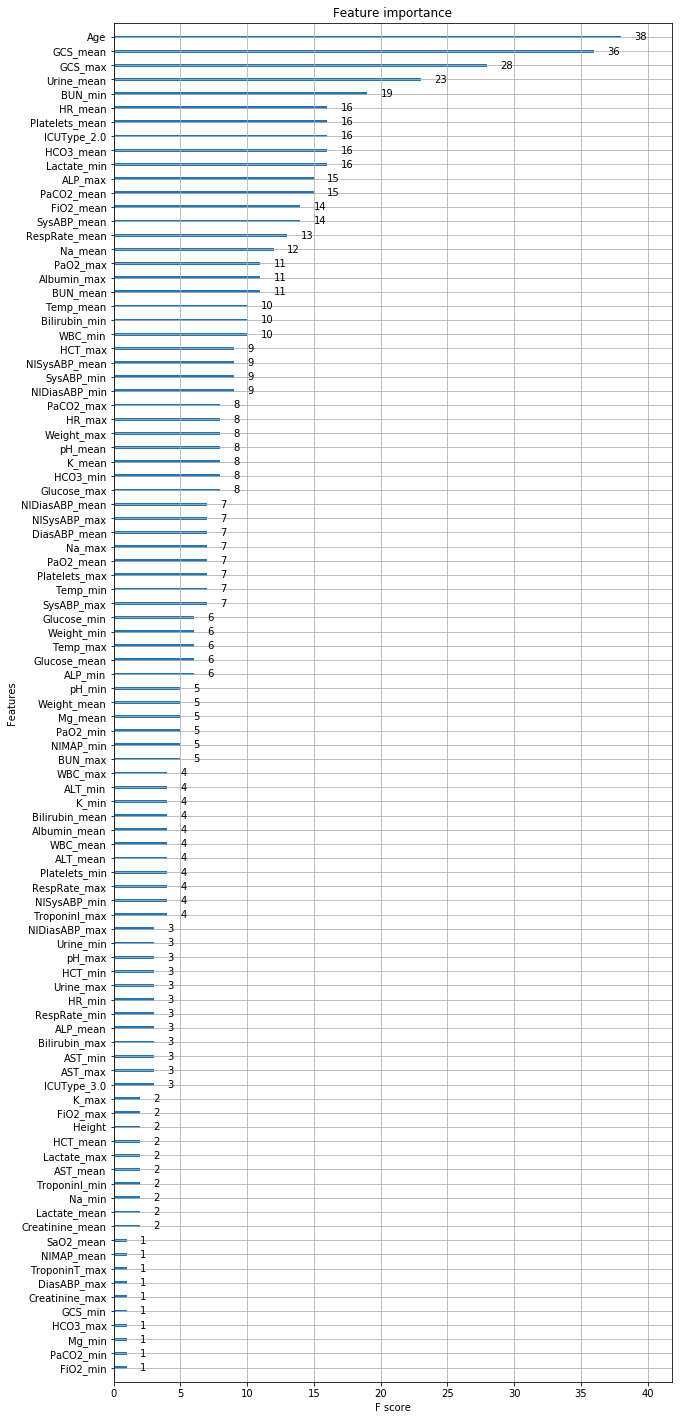

In [72]:
#plot importance of features
fig, ax = plt.subplots(figsize=(10, 25))
plot_importance(model, ax=ax)

In [73]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(model,threshold='mean')
selector.fit(train_X,train_y)
select = selector.get_support()

delete features which have 0 F score.

In [74]:
train_X = train_X.iloc[:,select]
test_X = test_X[list(train_X)]
watch_X = watch_X[list(train_X)]
train_X = train_X.reindex(sorted(train_X.columns),axis=1)
watch_X = watch_X.reindex(sorted(watch_X.columns),axis=1)
test_X = test_X.reindex(sorted(test_X.columns),axis=1)

------------------------------------------ separate ----------------------------------------------------------------------------

In [61]:
from hyperopt import hp, fmin, tpe

Do bayesian optimization, tune the hyperparameters based on training dataset and watching dataset.

In [75]:
space = {'max_depth': hp.quniform('max_depth',2,5,1),
         'learning_rate': hp.uniform('learning_rate',0.01,0.1),
         'n_estimators': hp.quniform('n_estimators',80,150,1),
         'gamma': hp.uniform('gamma',0,10),
         'min_child_weight': hp.uniform('min_child_weight',0,5),
         'max_delta_step': hp.uniform('max_delta_step',0,10),
         'subsample': hp.uniform('subsample',0.5,1),
         #'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
         'reg_alpha': hp.uniform('reg_alpha',0,10),
         'reg_lambda': hp.uniform('reg_lambda',0,10),
         'scale_pos_weight': hp.uniform('scale_pos_weight',3,5)
        }

In [76]:
def objective(params):
    bst = xgb.XGBClassifier(max_depth=int(params['max_depth']),learning_rate=params['learning_rate'],
                                n_estimators=int(params['n_estimators']),gamma=params['gamma'],
                                min_child_weight=params['min_child_weight'],max_delta_step=params['max_delta_step'],
                                subsample=params['subsample'], #colsample_bytree=params['colsample_bytree'], 
                                reg_alpha=params['reg_alpha'],reg_lambda=params['reg_lambda'],
                                scale_pos_weight=params['scale_pos_weight'])
    bst.fit(train_X,train_y)
    yhat = bst.predict(watch_X)
    tn, fp, fn, tp = metrics.confusion_matrix(watch_y, yhat).ravel()
    return 1-min(tp/(tp+fn),tp/(tp+fp))

Once obtain the best hyperparameters evaluated on watching dataset, evaluate on the actual testing dataset.

In [77]:
warnings.filterwarnings("ignore")
param = fmin(objective,space,algo=tpe.suggest,max_evals=20)
bst = xgb.XGBClassifier(max_depth=int(param['max_depth']),learning_rate=param['learning_rate'],
                            n_estimators=int(param['n_estimators']),gamma=param['gamma'],
                            min_child_weight=param['min_child_weight'],max_delta_step=param['max_delta_step'],
                            subsample=param['subsample'], #colsample_bytree=param['colsample_bytree'], 
                            reg_alpha=param['reg_alpha'],reg_lambda=param['reg_lambda'],
                            scale_pos_weight=param['scale_pos_weight'])
bst.fit(train_X,train_y)
yhat = bst.predict(test_X)
tn, fp, fn, tp = metrics.confusion_matrix(test_y, yhat).ravel()
min(tp/(tp+fn),tp/(tp+fp))

0.4730878186968839

--------------------------------------------- separate -----------------------------------------------------------------------

Save the hyperparameters used in the model.

In [79]:
df = open('param.txt','w')
df.write(str(param))
df.close()

In [80]:
param

{'gamma': 3.799867450224823,
 'learning_rate': 0.03935414274020397,
 'max_delta_step': 2.3862143511045932,
 'max_depth': 4.0,
 'min_child_weight': 1.5952900964003702,
 'n_estimators': 139.0,
 'reg_alpha': 0.7700688976193004,
 'reg_lambda': 4.211741953407701,
 'scale_pos_weight': 3.989241976613441,
 'subsample': 0.6607478712854162}

In [81]:
import shap

In [82]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap.force_plot(explainer.expected_value, shap_values[3998,:], test_X.iloc[3998,:])

In [83]:
shap.force_plot(explainer.expected_value, shap_values[19,:], test_X.iloc[19,:])

In [84]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

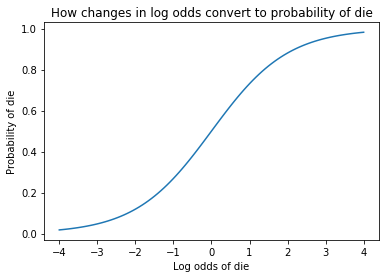

In [85]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of die")
plt.ylabel("Probability of die")
plt.title("How changes in log odds convert to probability of die")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

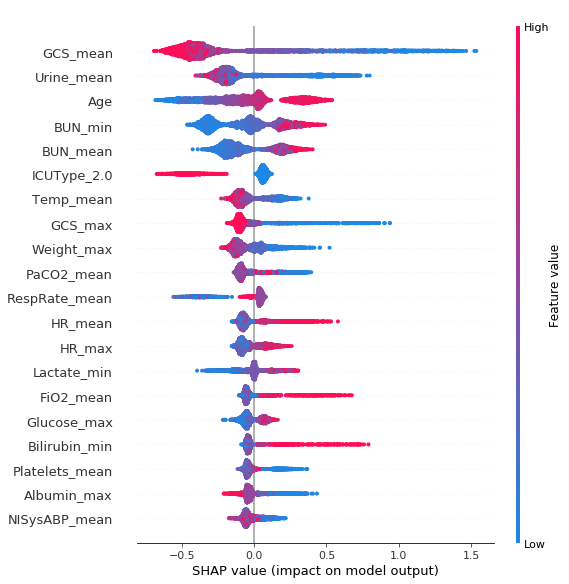

In [86]:
shap.summary_plot(shap_values, test_X)

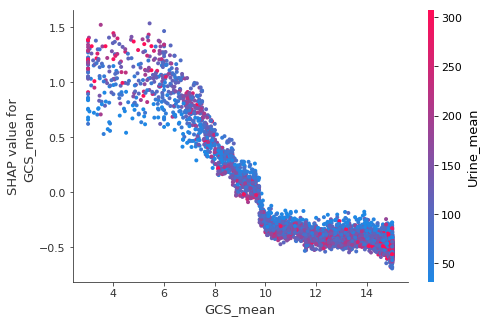

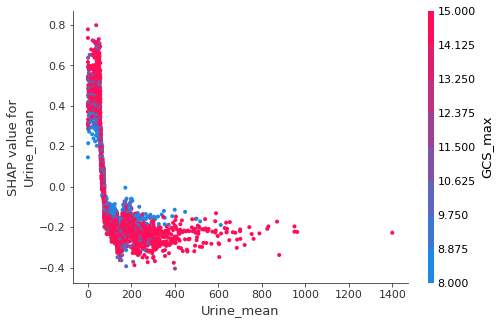

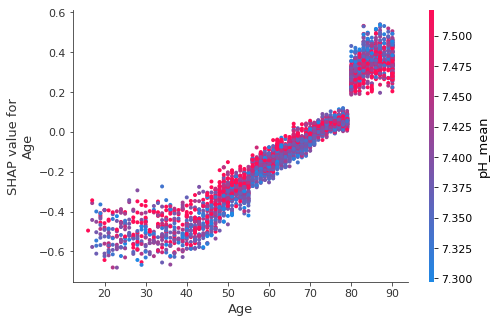

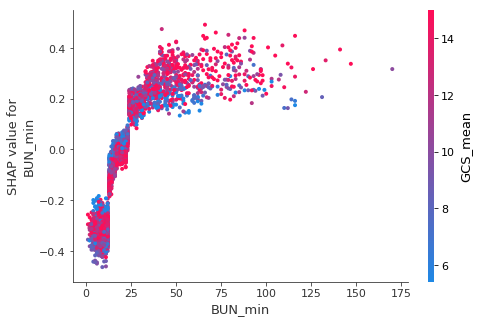

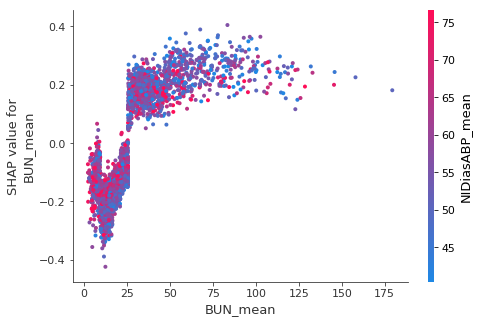

In [87]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, test_X)

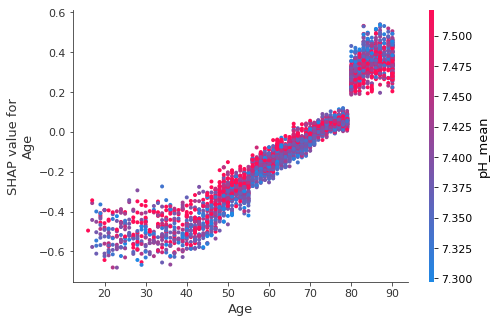

In [95]:
shap.dependence_plot("Age", shap_values, test_X)